## Import all the requiered libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

import torch
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn as nn

## Explore and prepare the dataset

In [83]:
df = pd.read_csv("dataset/dataset_membrane_.csv")

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SW         5216 non-null   float64
 1   MWCO       5216 non-null   int64  
 2   CA         5216 non-null   int64  
 3   ZP         5216 non-null   float64
 4   Permeance  5216 non-null   float64
 5   Rejection  5216 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 244.6 KB


In [85]:
df.head(5)

,SW,MWCO,CA,ZP,Permeance,Rejection
0,1.50778,350,87,-15.0,48.058984,0.742500
1,1.50778,350,87,-15.0,48.058984,0.351755
2,1.50778,350,87,-15.0,48.058984,0.364472
3,1.50778,350,87,-15.0,48.058984,0.232885
4,1.50778,350,87,-15.0,48.058984,0.098254


In [86]:
type(df['SW'][0])

numpy.float64

In [87]:
X = df.drop(['Permeance', 'Rejection'], axis=1)
y = df['Rejection']
y.head(5)

0    0.742500
1    0.351755
2    0.364472
3    0.232885
4    0.098254
Name: Rejection, dtype: float64

**Lets use Min Max Normalization to normalize all the seven features, transforming their values into a scale between 0 and 1.**

In [88]:
def normalize(dataset):
    data_normalized = ((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return data_normalized

In [89]:
features = normalize(df)
features

,SW,MWCO,CA,ZP,Permeance,Rejection
0,0.454667,0.571429,1.0,0.616438,0.741910,0.817718
1,0.454667,0.571429,1.0,0.616438,0.741910,0.541114
2,0.454667,0.571429,1.0,0.616438,0.741910,0.550116
3,0.454667,0.571429,1.0,0.616438,0.741910,0.456967
4,0.454667,0.571429,1.0,0.616438,0.741910,0.361663
...,...,...,...,...,...,...
5211,1.000000,0.142857,0.0,0.616438,0.047235,0.734593
5212,1.000000,0.142857,0.0,0.616438,0.047235,0.300520
5213,1.000000,0.142857,0.0,0.616438,0.047235,0.369577
5214,1.000000,0.142857,0.0,0.616438,0.047235,0.633118


## Pandas series to Numpy arrays

In [90]:
numpy_X = features[['SW','MWCO', 'CA', 'ZP']].to_numpy()
numpy_X[:5]

array([[0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836],
       [0.45466716, 0.57142857, 1.        , 0.61643836]])

In [91]:
numpy_y = y.to_numpy()
numpy_y[:5]

array([0.74249975, 0.35175509, 0.36447169, 0.23288501, 0.09825405])

## Create a train (70%) and a test (30%) set 

In [92]:
train_X, test_X, train_y, test_y = train_test_split(numpy_X, numpy_y, test_size=0.30, random_state=42)

## Numpy arrays to Pytorch tensors train

In [93]:
# this is for the train set.
tensor_X = torch.from_numpy(train_X).float() 
tensor_y = torch.from_numpy(train_y).float() 
print(tensor_X.shape, tensor_y.shape)

torch.Size([3651, 4]) torch.Size([3651])


In [94]:
tensor_y = tensor_y.unsqueeze(1)
print(tensor_X.shape, tensor_y.shape)

torch.Size([3651, 4]) torch.Size([3651, 1])


In [95]:
torch_dataset = Data.TensorDataset(tensor_X, tensor_y)

## Define a dataloader to load it in batches

In [96]:
total_samples = 4172

# Find divisors of the total number of samples
divisors = [i for i in range(1, total_samples + 1) if total_samples % i == 0]

# Print divisors
print("Divisors of", total_samples, "are:", divisors)
batch = 45 # we will have 149 iterations in each epoch. 4172 data divided by 28 data 
           # per batch, is equal to 75 batches or iterations to complete one epoch.

Divisors of 4172 are: [1, 2, 4, 7, 14, 28, 149, 298, 596, 1043, 2086, 4172]


In [97]:
loader = Data.DataLoader(
    dataset = torch_dataset,      # torch TensorDataset format
    batch_size = batch,           # mini batch size
    shuffle=True,                 # random shuffle for training
    num_workers=1,                # subprocesses for loading data
)

## Define a nn, optimizer, and loss function

In [98]:
model = nn.Sequential(nn.Linear(4, 10), # first layer
   nn.ReLU(),
   nn.Linear(10, 10), # second layer
   nn.ReLU(),
   nn.Linear(10, 10), # third layer
   nn.ReLU(),
   nn.Linear(10, 1), # fourth layer
   )

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss()

In [100]:
loss_lst = []
for epoch in range(1, 101):
    batch = 1
    print("Epoch", epoch)
    for step, (batch_x, batch_y) in enumerate(loader): 
        var_X, var_y = Variable(batch_x), Variable(batch_y)
        prediction = model(var_X)
        rmse_loss = torch.sqrt(loss_function(prediction, var_y))

        optimizer.zero_grad()
        rmse_loss.backward()
        optimizer.step()
        
        loss_lst.append(float(rmse_loss))
        print("Batch: ", batch, ", loss: ", rmse_loss)
        batch += 1
    print("Result of the last epoch's batch: ", rmse_loss)
    print(' ')

kward0>)
 
Epoch 97
Batch:  1 , loss:  tensor(0.3490, grad_fn=<SqrtBackward0>)
Batch:  2 , loss:  tensor(0.2977, grad_fn=<SqrtBackward0>)
Batch:  3 , loss:  tensor(0.3119, grad_fn=<SqrtBackward0>)
Batch:  4 , loss:  tensor(0.2972, grad_fn=<SqrtBackward0>)
Batch:  5 , loss:  tensor(0.2763, grad_fn=<SqrtBackward0>)
Batch:  6 , loss:  tensor(0.2566, grad_fn=<SqrtBackward0>)
Batch:  7 , loss:  tensor(0.3274, grad_fn=<SqrtBackward0>)
Batch:  8 , loss:  tensor(0.2768, grad_fn=<SqrtBackward0>)
Batch:  9 , loss:  tensor(0.3063, grad_fn=<SqrtBackward0>)
Batch:  10 , loss:  tensor(0.2873, grad_fn=<SqrtBackward0>)
Batch:  11 , loss:  tensor(0.3203, grad_fn=<SqrtBackward0>)
Batch:  12 , loss:  tensor(0.3024, grad_fn=<SqrtBackward0>)
Batch:  13 , loss:  tensor(0.3345, grad_fn=<SqrtBackward0>)
Batch:  14 , loss:  tensor(0.2947, grad_fn=<SqrtBackward0>)
Batch:  15 , loss:  tensor(0.3009, grad_fn=<SqrtBackward0>)
Batch:  16 , loss:  tensor(0.2939, grad_fn=<SqrtBackward0>)
Batch:  17 , loss:  tensor(0.

In [101]:
# Save the model state dictionary
torch.save(model.state_dict(), 'models/StateMlRej.pth')

# Save the entire model
torch.save(model, 'models/MlPRej.pth')

In [120]:
#Load the Saved Model
model = torch.load('models/MlPRej.pth')
model.load_state_dict(torch.load('models/StateMlRej.pth'))
model.eval()

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

## Plot the loss per epoch in training

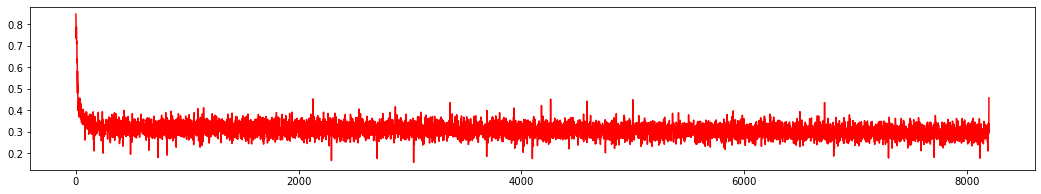

In [121]:
plt.figure(figsize=(18,3)) 
plt.plot(loss_lst, c='red')
plt.show()

## Test our Artificial Neural Network

**Convert Numpy arrays to Pytorch tensors for testing set.**

In [122]:
# this is for the test set.
tensor_X_test = torch.from_numpy(test_X).float() 
tensor_y_test = torch.from_numpy(test_y).float() 
print(tensor_X_test.shape, tensor_y_test.shape)

tensor_y_test = tensor_y_test.unsqueeze(1)
print(tensor_X_test.shape, tensor_y_test.shape)

torch.Size([1565, 4]) torch.Size([1565])
torch.Size([1565, 4]) torch.Size([1565, 1])


In [123]:
var_X_test = Variable(tensor_X_test)
var_y_test = Variable(tensor_y_test)
print(var_y_test)

tensor([[ 0.9700],
        [ 0.5138],
        [ 0.2677],
        ...,
        [ 0.8862],
        [-0.0582],
        [ 0.9000]])


**Do predictions of the testing set and calculate the RMSE.**

In [124]:
with torch.no_grad():
 predictions = model(var_X_test)

In [125]:
# Calculate prediction accuracy
correct = (predictions.argmax(dim=1) == var_y_test).sum().item()
total = var_y_test.size(0)
accuracy = correct / total
print(f'Accuracy: {correct}')

Accuracy: 0


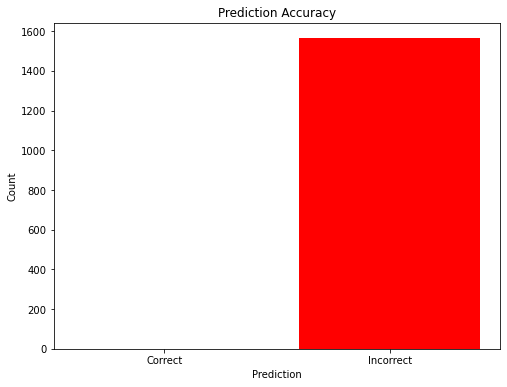

In [126]:
# Plot the prediction accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Prediction Accuracy')
plt.show()

In [127]:
y_pred = predictions.tolist()
y_real = var_y_test.tolist()

In [129]:
# Save predictions as a CSV file
predictions_df = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
predictions_df.to_csv('MLPRejectio.csv', index=False)
#Save to Excel
dframe = pd.DataFrame({'GroundTruth': var_y_test.squeeze().numpy(),
                       'Prediction': predictions.squeeze()})
dframe.to_excel('MLPRejectio.xlsx', index=True)

In [130]:
rmse_loss = torch.sqrt(loss_function(predictions, var_y_test))

In [131]:
rmse_loss

tensor(0.3005)

## Plot the predictions against target values

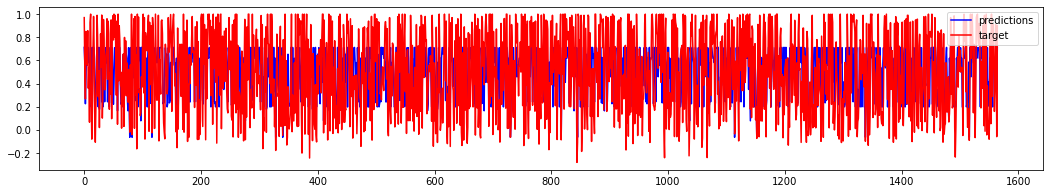

In [132]:
plt.figure(figsize=(18,3)) 
plt.plot(y_pred, c='blue', label="predictions")
plt.plot(y_real, c='red', label="target")
plt.legend(loc="upper right")
plt.show()

## Predict JUST one data with our model

In [133]:
data_x = var_X_test[0]
data_x

tensor([0.1206, 0.0000, 0.4717, 1.0000])

In [134]:
prediction = model(data_x)

In [135]:
print("Target value: ", var_y_test[0])
print("Prediction: ", prediction)

Target value:  tensor([0.9700])
Prediction:  tensor([0.7126], grad_fn=<ViewBackward0>)


**When predicting only one data, the first one of the testing set, it can be seen that the target or real value is 28 MPG and that the prediction is 26.7. The prediction is really close and has an absolute error of 1.3 MPG or a percentage error of 4.6%.**